# **ASL Letter Recognition**
> ***by : Mahmoud Nada***

# Setting up The Environment 

> First we need this important imports.

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import os
from keras.preprocessing.image import ImageDataGenerator
import cv2 as cv
from sklearn.model_selection import train_test_split
import keras
import matplotlib.pyplot as plt
import pandas as pd
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense,BatchNormalization
from keras.models import Sequential
from keras import regularizers
import pickle
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
import seaborn as sns
from keras import applications
from keras.models import Model

Using TensorFlow backend.


> *   This step is important to change my notebook environment to google drive where may datasets are.
*   If you are Running this code on a local machine there is no need for this code cell. 

In [2]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/ASL Dataset')
os.listdir()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


['asl_alphabet_test',
 'asl_alphabet_train',
 'asl-alphabet-eval',
 'MobileNet.h5',
 'variables2.pickle',
 'variables.pickle',
 'Data.pickle',
 'InceptionV3.h5',
 'ResNet.h5',
 'Local1.h5',
 'eval_data.pickle',
 'VGG16.h5',
 'VGG16_Eval.h5',
 'Inception_Eval.h5',
 'Inception.h5',
 'VGG16_2.h5',
 'ResNet1.h5',
 'Vgg19_1.h5',
 'MobileNet_1.h5',
 'DenseNet_1.h5',
 'CustomeData.pickle',
 'CustomeData.rar',
 'MobileNetV2_1.h5',
 'Inception_1.h5',
 'nasnet.NASNetLarge_1.h5',
 'Local3.h5',
 'Capstone Project Report.docx',
 'Local2.h5',
 'VGG16_3.h5',
 'Capstone Project Report.pdf']

> *  Before we begin importing our dataset we save the location of their directories.
*  Also let's see what labels do we have in the training dataset by listing the directories in the dataset and printing them.

In [3]:
train_path = './asl_alphabet_train'
test_path = './asl_alphabet_test'
Ulabels = sorted(os.listdir(train_path))
print(Ulabels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


# Data Pre-Processing

> In order to import our images from the pre-specified directories I made a function that iterates on all the directories within the labels we extrated earlier, this function also resizes the images to 64x64 pixels images to make it easy for me to store and train other wise it will consume all Colab's RAMs and the training process will take forever.

In [0]:
def load_images(directory, size):
    images = []
    lab = []
    i = 0
    j = size
    for idx, label in enumerate(Ulabels):
        for file in os.listdir(directory + "/" + label):
            i += 1
            file_path = directory + "/" + label + "/" + file
            print(i, "Uploaded", "-", round(((i/j) * 100), 3), "%")
            image = cv.resize(cv.imread(file_path), (64,64))
            images.append(image)
            lab.append(idx)
    images = np.array(images)
    lab = np.array(lab)
    return(images, lab)

> To load the images we need to specify thier directory path.

In [0]:
images, labels = load_images(train_path)

> To check on the distribution of the images in our dataset we use seaborn to accomplish this task.

In [0]:
df = pd.DataFrame()
df["labels"]=labels
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)

> After Extracting the images with their corresponding labels from directories it's time to split them into training and testing sets. 

In [0]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.1, stratify = labels)

> Importing 87000 images from their directories took too long on Google Colab, So instead of loading the dataset each time we run this code I used **Pickle** library to store our dataset after spliting them to be always ready for us to use.  

In [0]:
Data = [X_train, X_test, y_train, y_test]
with open('./Data.pickle', 'wb') as f:
  pickle.dump(Data, f)

> Now Every time I work on this code I just run the code cell below to save me huge time and effort, So if this is the first time you run this code you should ignore this cell if not you should go straight to here and run this code.

In [0]:
with open('./Data.pickle', 'rb') as f:
  loaded_list = pickle.load(f)
X_train, X_test, y_train, y_test = loaded_list

> Now let's check our data that we imported.

In [0]:
n = len(Ulabels)
train_n = len(X_train)
test_n = len(X_test)

print("Total number of symbols: ", n)
print("Number of training images: " , train_n)
print("Number of testing images: ", test_n)

Total number of symbols:  29
Number of training images:  78300
Number of testing images:  8700


> To be able to see whether the images has similarities or not it's useful to plot color pixels intinsity of the images in the dataset.

In [0]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);

> It tured out that the images unfortunatly have too many similarities and there is a possibility of overfitting or not well generalization at the end.

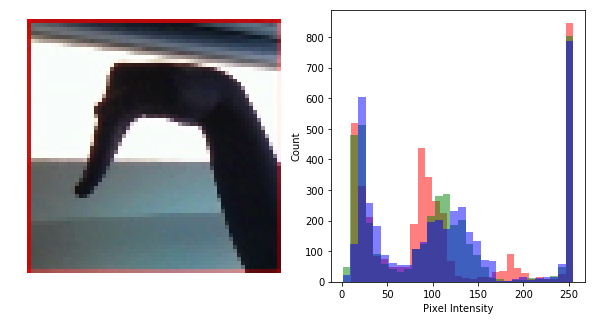

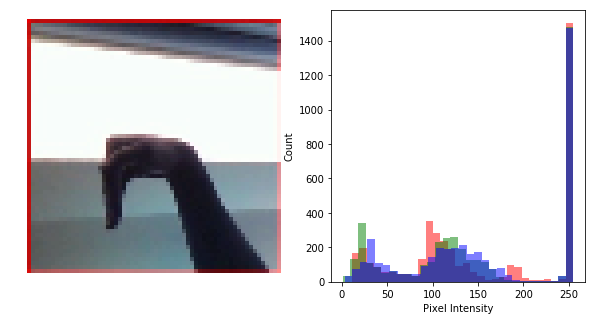

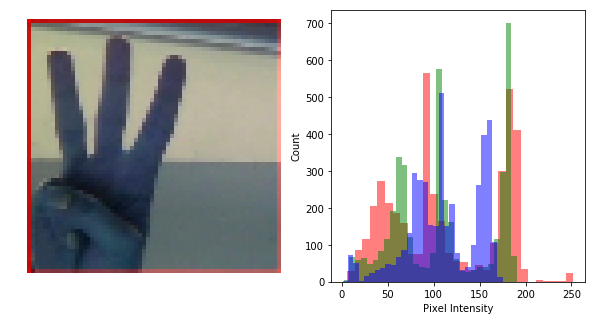

In [0]:
plotHistogram(X_train[1])
plotHistogram(X_train[10000])
plotHistogram(X_train[30000])

To aslo check on the distribution of the images in our training and testing sets we aslo use seaborn.

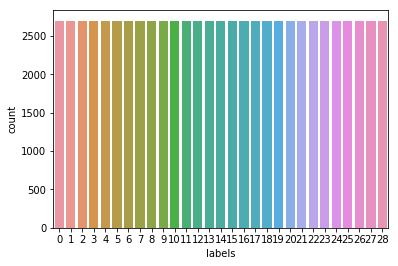

In [0]:
df = pd.DataFrame()
df["labels"]=y_train
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)

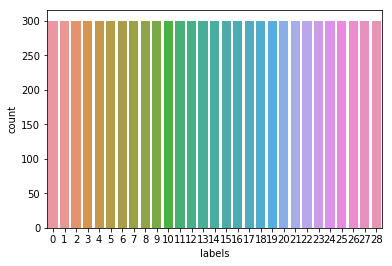

In [0]:
df = pd.DataFrame()
df["labels"]=y_test
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)

> It would be helpfull to plot samples of the images, So this below function is used for this specific task, it takes set of images that are sorted and prints a sample of each class.

In [0]:
def plot_images(images):
    n = int(len(images) / len(Ulabels))
    cols = 8
    rows = 4
    fig = plt.figure(figsize = (24,12))
    
    for i in range(len(Ulabels)):
        ax = plt.subplot(rows, cols, i+1)
        plt.imshow(images[int(n*i)])
        plt.title(Ulabels[i])
        ax.title.set_fontsize(20)
        ax.axis('off')
    plt.show()

> Before ploting the our samples we need to sort them. 

In [0]:
y_train_in = y_train.argsort()
y_train = y_train[y_train_in]
X_train = X_train[y_train_in]

> Now we have sorted the training set we now plot them.

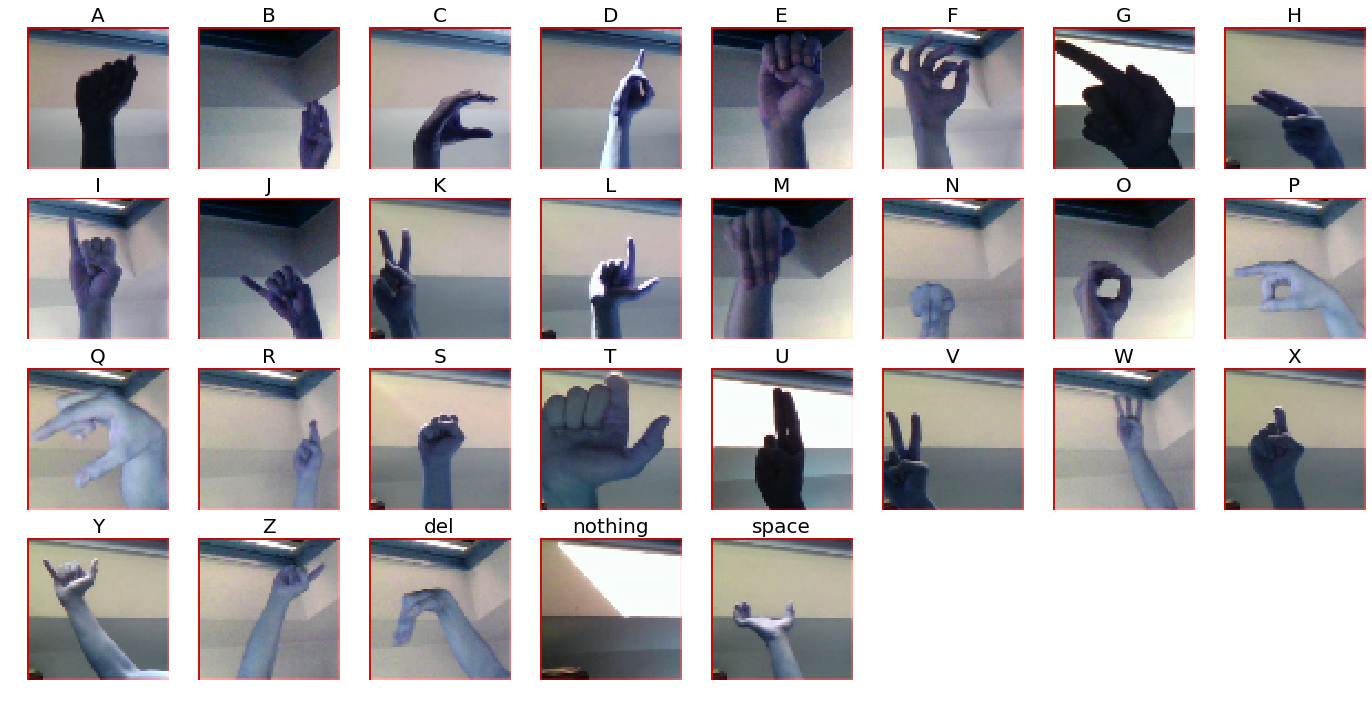

In [0]:
plot_images(X_train)

> Same for the testing set.

In [0]:
y_test_in = y_test.argsort()
y_test = y_test[y_test_in]
X_test = X_test[y_test_in]

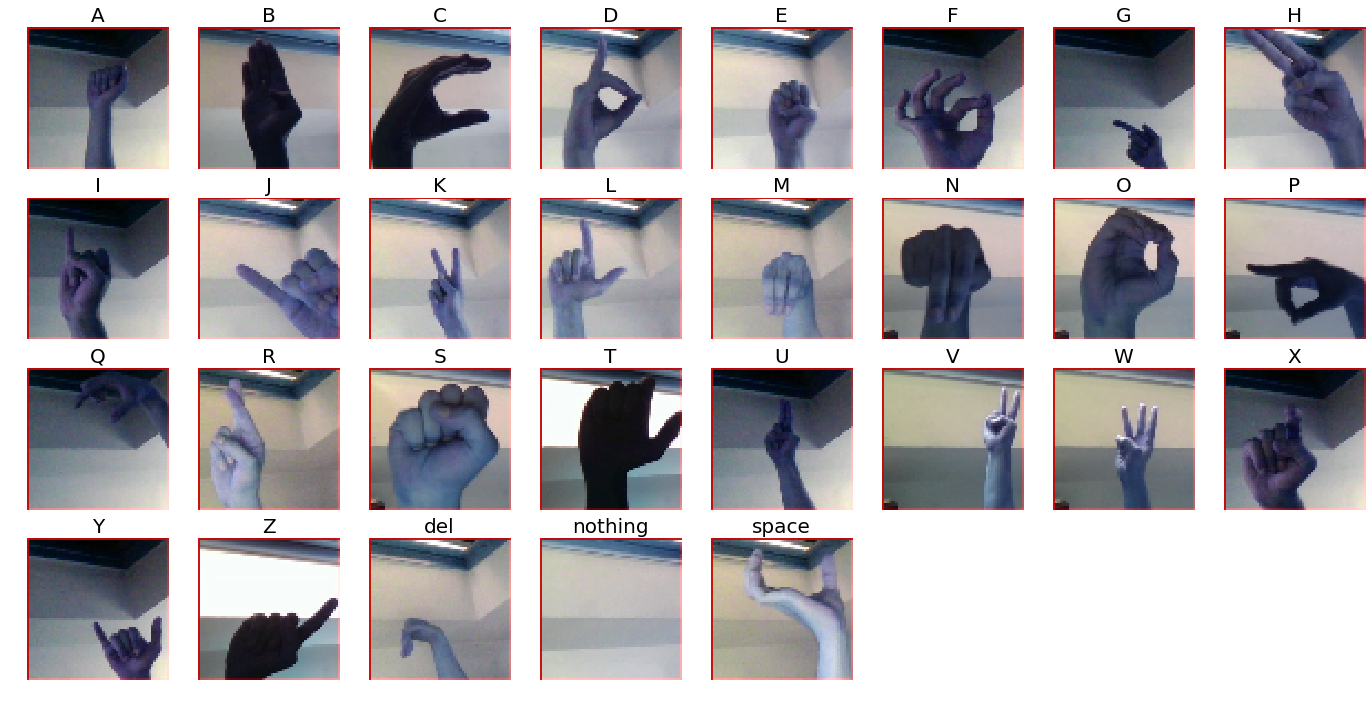

In [0]:
plot_images(X_test)

> **Now after we *have* seen how the data looks like we get it ready for training and pre-process it.**
---

> This is a multi class classification problem, So we need to one hot encode the labels of our datasets.

In [0]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
# This is how a row would look like after one hot encoded.
print(y_train[0])
print(len(y_train[0]))

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]
29


> Now there is only one step till training the model which is Normalizing RGB values, we divide all images by 255 the range can be described with a 0.0-1.0 where 0.0 means 0 (0x00 in hex) and 1.0 means 255 (0xFF in hex). Normalization will help us remove distortions caused by lights and shadows in an image.

In [0]:
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0

# Defining a model and Training Process
After multiple data pre-processing steps we know move to the next task. 

---



> First Step is to create a model, So i created a function that does that and returns the crearted model.

In [0]:
def create_model():
    model = Sequential()
    model.add(Conv2D(8, kernel_size=[3, 3], padding='same', activation='relu',
                     input_shape= (64,64,3)))
    model.add(Conv2D(16,kernel_size=[3, 3],padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=[3, 3]))
    
    model.add(Conv2D(16,kernel_size=[3, 3],padding='same', activation='relu'))
    model.add(Conv2D(32,kernel_size=[3, 3],padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=[3, 3]))
    model.add(Dropout(0.5))

    model.add(Conv2D(32,kernel_size=[3, 3],padding='same', activation='relu'))
    model.add(Conv2D(64,kernel_size=[3, 3],padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=[3, 3]))
    model.add(Dropout(0.5))

    #model.add(Conv2D(64,kernel_size=[3,3],padding='same', activation='relu'))
    #model.add(Conv2D(128,kernel_size=[3,3],padding='same', activation='relu'))
    #model.add(MaxPooling2D(pool_size=[3,3]))
    
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(GlobalAveragePooling2D())
    #model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    #model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

    model.add(Dense(29, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    model.summary()
    print("[-] Model is ready")
    return model

> Before we build the function that fits our model we need to build a monitor that tracks the progress of our training process and saves the best training results only, it also saves lots of time because this monitor stops the training process after a pre-defined number of iterations that has no progress in performance, So this monitor is really helpfull. 

In [0]:
checkpoint = ModelCheckpoint("Local2.h5",
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1)
early = EarlyStopping(monitor='val_acc',
                      min_delta=0.001,
                      patience=10,
                      verbose=1,
                      mode='auto')

> Let's also build a function that fits our model for us to these spcified hyper-parameters.

In [0]:
def fit_model(model):
    model_hist = model.fit(X_train, y_train, batch_size=128, epochs=50, 
                           validation_data = [X_test, y_test],
                           callbacks = [checkpoint, early])
    return model_hist

> Now it's time to create the Model.

In [0]:
model = create_model()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 64, 64, 8)         224       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 16)        1168      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 21, 21, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 21, 21, 16)        2320      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 21, 21, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 32)         

> Then lets fit our model to our data and saves the history of this training process in a varaible that will be used later.

In [0]:
hist = fit_model(model)

Train on 78300 samples, validate on 8700 samples
Epoch 1/50
78300/78300 [==============================] - 22s 281us/step - loss: 2.4453 - acc: 0.2737 - val_loss: 1.0587 - val_acc: 0.7141

Epoch 00001: val_acc improved from -inf to 0.71414, saving model to Local2.h5
Epoch 2/50
78300/78300 [==============================] - 21s 271us/step - loss: 1.0180 - acc: 0.6629 - val_loss: 0.4167 - val_acc: 0.8872

Epoch 00002: val_acc improved from 0.71414 to 0.88724, saving model to Local2.h5
Epoch 3/50
78300/78300 [==============================] - 21s 271us/step - loss: 0.6628 - acc: 0.7699 - val_loss: 0.2663 - val_acc: 0.9270

Epoch 00003: val_acc improved from 0.88724 to 0.92701, saving model to Local2.h5
Epoch 4/50
78300/78300 [==============================] - 21s 271us/step - loss: 0.5119 - acc: 0.8210 - val_loss: 0.1896 - val_acc: 0.9451

Epoch 00004: val_acc improved from 0.92701 to 0.94506, saving model to Local2.h5
Epoch 5/50
78300/78300 [==============================] - 21s 271us/st

> The History variable That we saved earlier now will be usefull for plotting the accuracy and loss of our model at each epoch, this history keeps record of all training process and with the helper functions plot_accuracy and plot_loss we can have a rich plot with this information.


In [0]:
def plot_accuracy(hist):
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.legend(['train', 'test'], loc= 'lower right')
    plt.title('train Vs test Accuracy')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.show()

def plot_loss(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.legend(['train loss', 'test loss'], loc= 'upper right')
    plt.title('train Vs test loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

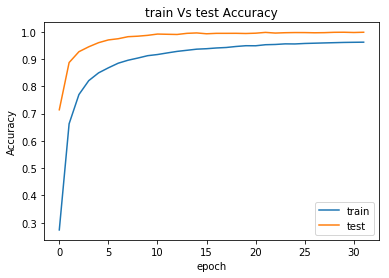

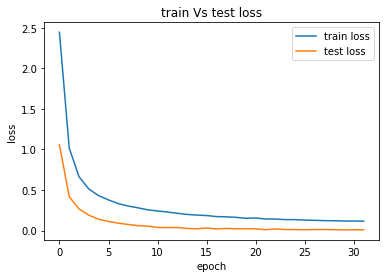

In [0]:
plot_accuracy(hist)
plot_loss(hist)

# Model Evaluation and Validation
At this point we reached an acceptable model that performs well at the testing and training data, let's make sure that this model performs well at an outside images that did not exist in the training or the testing sets. 

---



> This helper function imports images of validation images, we do the same pre-processing steps at the training images here too.

In [0]:
def load_test_data():
    images = []
    names = []
    size = 64,64
    for image in os.listdir(test_path):
        temp = cv.imread(test_path + '/' + image)
        temp = cv.resize(temp, size)
        images.append(temp)
        names.append(image)
    images = np.array(images)
    images = images.astype('float32')/255.0
    return images, names

> Then we store the validation images in test_images and test_labels variables

In [0]:
test_images, test_labels = load_test_data()

> To get the predictions of the validation images I built a function that takes the validaion images and returns the predicted labels.

In [0]:
def get_predictions(test_data, model):
    prediction_classes = []
    for image in test_data:
        image = image.reshape(1,64,64,3)
        #pred = model.predict_classes(image)
        pred = model.predict(image)
        prediction_classes.append(np.argmax(pred, axis=1)[0])
    return prediction_classes

> lets save the predicted labels in a variable and use it later.

In [0]:
predictions = get_predictions(test_images, model)

>  We now have the predicted labels but in numeric form, to translate this form to the original labels I built this get_labels function that returns labels in categorical form.

In [0]:
labels_dict = {}
for i ,l in enumerate(Ulabels):
    labels_dict[l] = i

def get_labels(predictions):
    predictions_labels= []
    for i in range(len(predictions)):
        for ins in labels_dict:
            if predictions[i] == labels_dict[ins]:
                predictions_labels.append(ins)
                break
    return predictions_labels

> Now let's see how our model Performed on the strange outsider images, I'll plot the validation images and above each the predicted label and it's original label.

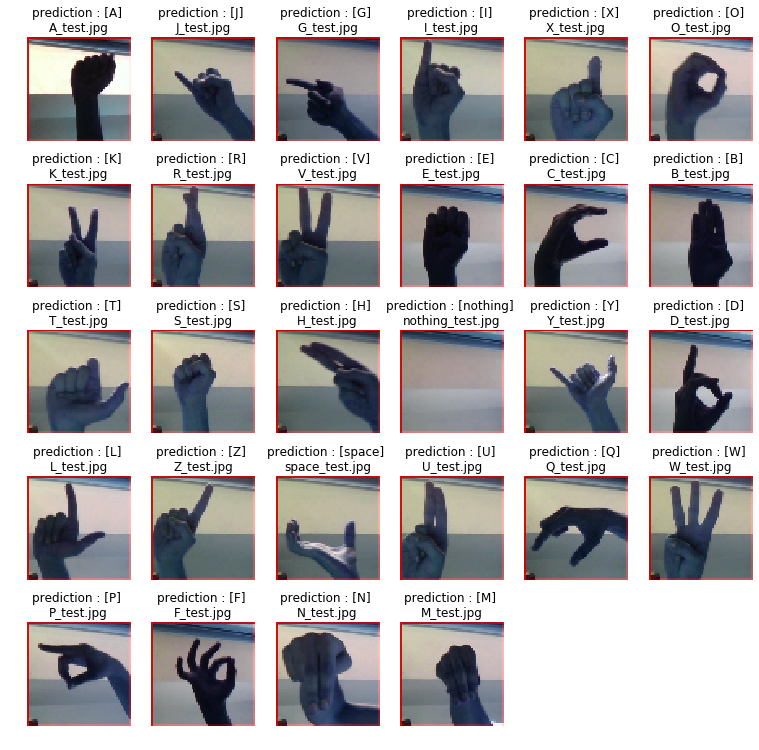

In [0]:
pred_lab = get_labels(predictions)

predfigure = plt.figure(figsize = (13,13))
def plot_image_1(fig, image, label, prediction, predictions_label, row, col, index):
    fig.add_subplot(row, col, index)
    plt.axis('off')
    plt.imshow(image)
    title = "prediction : [" + str(predictions_label) + "] "+ "\n" + label
    plt.title(title)
    return

image_index = 0
row = 5
col = 6
for i in range(1,(row*col-1)):
    plot_image_1(predfigure, test_images[image_index], test_labels[image_index], predictions[image_index], pred_lab[image_index], row, col, i)
    image_index = image_index + 1
plt.show()


> **Now as we can see the all the model's prediction were correct, this justifies that the model is reliable and can be accepted as the final model.** 
---



# Using Transfer Learning
Now we can try some of the pre-trained models to see if it makes any improvments in performance.
> I tried multiple Transfer Learning Model including:
*  VGG16 
*  VGG-19
*  ResNet
*  MobileNet
*  MobileNetV2

>The best model was VGG16 so this code below will describe how i trained VGG16 with my data, other have pretty much the same methode.

> First, from Keras applications we select the model we want, you can find all model in the link: https://keras.io/applications , in our case we will choose VGG16 (trained on the imagenet dataset for a thousand classes) and exclude it's top fully connecting layers to replace it with mine. 

In [0]:
model = applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

>We import the VGG16 model without its last layer and add a few dense layers so that our model can learn more complex functions and a Global Average Pooling layer to reduce dimentionalty and minimize overfitting.

In [0]:
x=model.output
#x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding="same")(x)
x = Dropout(0.5)(x)
x=GlobalAveragePooling2D()(x)
#x = Flatten()(x)
#x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
#x=Dense(512,activation='relu')(x) #dense layer 2
#x=Dense(256,activation='relu')(x) #dense layer 3
#x=Dense(128,activation='relu')(x) #dense layer 3
preds=Dense(29,activation='softmax')(x) #final layer with softmax activation

custom_model = Model(input=model.input, output=preds)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if sys.path[0] == '':


> To check the architecture of our model, we simply need to use this line of code given below.

In [0]:
for i, layer in enumerate(custom_model.layers):
    print(i,layer.name)

0 input_2
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 dropout_8
20 global_average_pooling2d_4
21 dense_4


>Now that we have our model, as we will be using the pre-trained weights, that our model has been trained on (imagenet dataset), we have to set all the weights to be non-trainable. We will only be training the last Dense layers that we have made previously. 

In [0]:
for layer in model.layers:
    layer.trainable=False

> As we did above I made a monitor to this model too.

In [0]:
checkpoint2 = ModelCheckpoint("VGG16_3.h5",
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1)
early2 = EarlyStopping(monitor='val_acc',
                      min_delta=0,
                      patience=20,
                      verbose=1,
                      mode='auto')

> After building the monitor we compile and fit our model to our data.

In [0]:
custom_model.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])
custom_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0   

In [0]:
custom_model_hist = custom_model.fit(X_train, y_train,
                 validation_data=(X_test, y_test),
                 epochs=100, batch_size=1024, callbacks=[checkpoint2, early2], verbose=1)

Train on 78300 samples, validate on 8700 samples
Epoch 1/100
78300/78300 [==============================] - 64s 819us/step - loss: 0.6082 - acc: 0.8167 - val_loss: 0.3649 - val_acc: 0.9369

Epoch 00001: val_acc improved from 0.93529 to 0.93690, saving model to VGG16_3.h5
Epoch 2/100
78300/78300 [==============================] - 65s 825us/step - loss: 0.6040 - acc: 0.8177 - val_loss: 0.3621 - val_acc: 0.9351

Epoch 00002: val_acc did not improve from 0.93690
Epoch 3/100
78300/78300 [==============================] - 64s 823us/step - loss: 0.6052 - acc: 0.8172 - val_loss: 0.3599 - val_acc: 0.9359

Epoch 00003: val_acc did not improve from 0.93690
Epoch 4/100
78300/78300 [==============================] - 65s 824us/step - loss: 0.6060 - acc: 0.8163 - val_loss: 0.3579 - val_acc: 0.9356

Epoch 00004: val_acc did not improve from 0.93690
Epoch 5/100
78300/78300 [==============================] - 65s 824us/step - loss: 0.6001 - acc: 0.8196 - val_loss: 0.3557 - val_acc: 0.9367

Epoch 00005: v

>Now we plot the accurcy and loss of our custome model. 

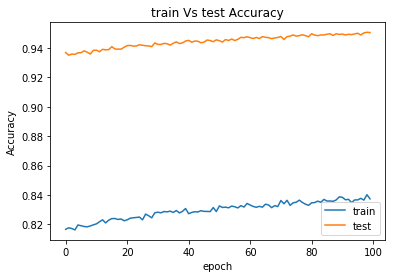

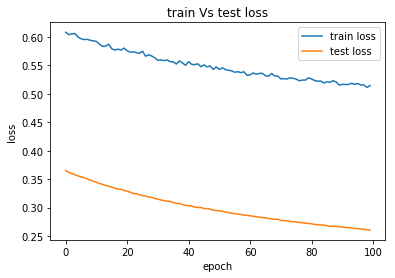

In [0]:
plot_accuracy(custom_model_hist)
plot_loss(custom_model_hist)

In [0]:
custom_model_hist.model.evaluate(X_test, y_test)

8700/8700 [==============================] - 10s 1ms/step


[0.26065048338984537, 0.9504597701149425]

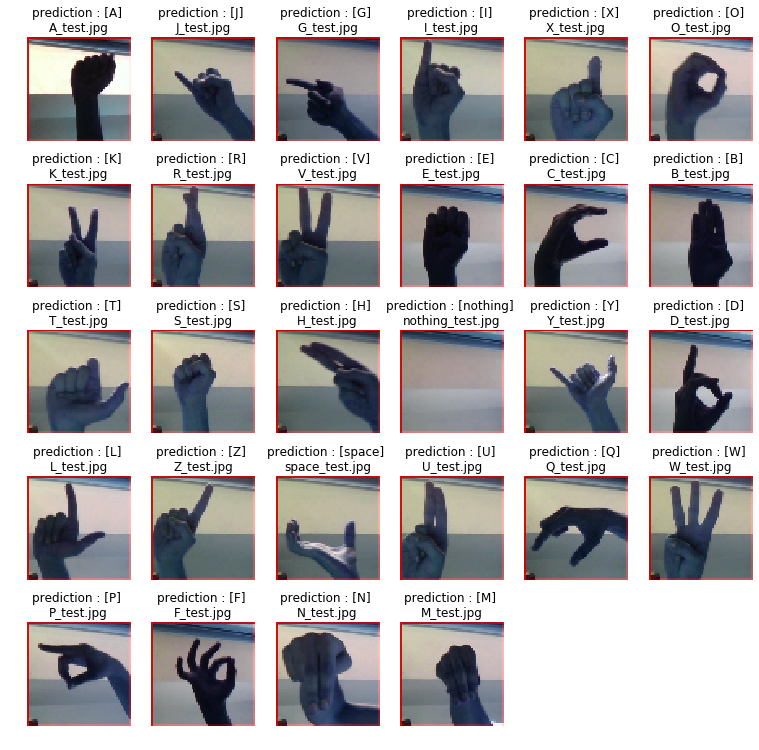

In [17]:
predictions2 = get_predictions(test_images, custom_model_hist.model)
pred_lab2 = get_labels(predictions2)

predfigure = plt.figure(figsize = (13,13))
def plot_image_1(fig, image, label, prediction, predictions_label, row, col, index):
    fig.add_subplot(row, col, index)
    plt.axis('off')
    plt.imshow(image)
    title = "prediction : [" + str(predictions_label) + "] "+ "\n" + label
    plt.title(title)
    return

image_index = 0
row = 5
col = 6
for i in range(1,(row*col-1)):
    plot_image_1(predfigure, test_images[image_index], test_labels[image_index], predictions2[image_index], pred_lab2[image_index], row, col, i)
    image_index = image_index + 1
plt.show()

> **As we can see the transfer learning model is also reliable and has a great performance.**